In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

def schwefel(coordinates):
    return 418.9829 * len(coordinates) - np.sum(coordinates * np.sin(np.sqrt(np.abs(coordinates))))

def generate_particle(dim, bounds, idx):
    position = np.random.uniform(bounds[0], bounds[1], dim)
    velocity = np.zeros(dim)
    return {
        "id": idx,
        "position": position,
        "velocity": velocity,
        "personal_best_position": np.copy(position),
        "personal_best_score": schwefel(position),
    }

def generate_population(dim, bounds, population_size):
    return [generate_particle(dim, bounds, i) for i in range(population_size)]

def best_circ_neighbor(particles, index, neighborhood_size):
    scores = [p["personal_best_score"] for p in particles]
    neighbors = [(index + i) % len(particles) for i in range(-neighborhood_size, neighborhood_size + 1) if i != 0]
    best_idx = min(neighbors, key=lambda i: scores[i])
    return particles[best_idx]["personal_best_position"]

def save_population_to_file(particles, generation, filename="population_log_PSO.csv"):
    df = pd.DataFrame([
        {
            "generation": generation,
            "id": p["id"],
            **{f"gene_{i}": p["position"][i] for i in range(len(p["position"]))}
        }
        for p in particles
    ])
    df.to_csv(filename, mode="a", header=not os.path.exists(filename), index=False)

def pso(
    dimensions,
    population_size,
    generations,
    initial_inertia,
    final_inertia,
    bounds,
    c1, c2,
    topology="global",
    neighborhood_size=2,
    vmax_factor=0.2
):
    particles = generate_population(dimensions, bounds, population_size)
    vmax = vmax_factor * (bounds[1] - bounds[0])
    
    if os.path.exists("population_log_PSO.csv"):
        os.remove("population_log_PSO.csv")

    global_best_position = min(particles, key=lambda p: p["personal_best_score"])["personal_best_position"]
    global_best_score = min(p["personal_best_score"] for p in particles)

    fitness_history = []

    for gen in range(generations):
        inertia = initial_inertia - (initial_inertia - final_inertia) * gen / generations
        save_population_to_file(particles, gen)

        for i, particle in enumerate(particles):
            if topology == "global":
                best_position = global_best_position
            elif topology == "ring":
                best_position = best_circ_neighbor(particles, i, neighborhood_size)

            r1 = np.random.rand(dimensions)
            r2 = np.random.rand(dimensions)

            particle["velocity"] = (
                inertia * particle["velocity"]
                + c1 * r1 * (particle["personal_best_position"] - particle["position"])
                + c2 * r2 * (best_position - particle["position"])
            )
            particle["velocity"] = np.clip(particle["velocity"], -vmax, vmax)

            particle["position"] += particle["velocity"]
            particle["position"] = np.clip(particle["position"], bounds[0], bounds[1])

            fitness = schwefel(particle["position"])
            if fitness < particle["personal_best_score"]:
                particle["personal_best_score"] = fitness
                particle["personal_best_position"] = np.copy(particle["position"])

        current_best = min(particles, key=lambda p: p["personal_best_score"])
        if current_best["personal_best_score"] < global_best_score:
            global_best_score = current_best["personal_best_score"]
            global_best_position = np.copy(current_best["personal_best_position"])

        fitness_history.append(global_best_score)

    plt.plot(fitness_history)
    plt.xlabel("Generace")
    plt.ylabel("Nejlepší fitness")
    plt.title("PSO konvergence")
    plt.grid()
    plt.show()

    print(f"Nejlepší nalezená hodnota: {global_best_score:.6f}")
    return particles

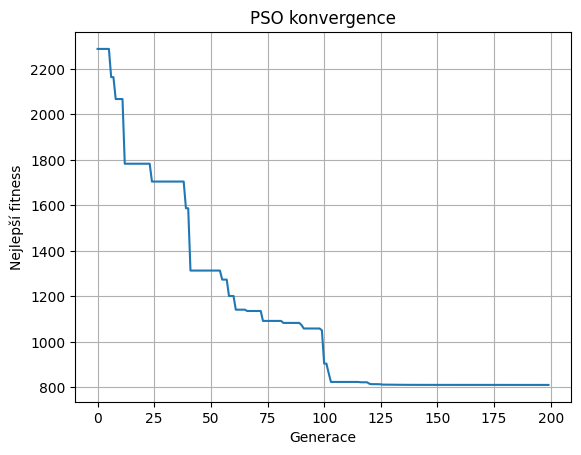

Nejlepší nalezená hodnota: 810.848568


In [ ]:
final_particles = pso(
    dimensions=10,
    population_size=100,
    generations=200,
    initial_inertia=0.9,
    final_inertia=0.4,
    bounds=(-500, 500),
    c1=2.0,
    c2=2.0,
    topology="global"
)